In [21]:
import graphviz

#RICORDARSI DI CAMBIARE SOURCE E SINK OGNI QUALVOLTA SI CAMBIA IL GRAFO


PATH_COVER_COLORS = ["orange", "blue", "purple", "brown", "green", "red"]

nomeGrafo = "Grafo 1"
source = "Am"
sink = "Ip"
topological_order = []
predecessor = {}
predecessor_path = []
cover = []
color = {}
u = {}
m = {}
demand = {}
path_flow = {}



#Procedura che permette di leggere un grafo in formato Graphviz e lo elabora
#in un dizionario gestibile dal seguente codice:

def graphviz_reader(nome_file : str) -> dict:

    grafo = {}
    file = open(f"Grafi/{nome_file}.dot", mode="r")
    lines = file.readlines()
    lines.pop(0)
    lines.pop(0)
    lines.pop(len(lines) - 1)

    for line in lines:

        values = line.strip()
        edge = values.split(" -> ")

        if edge[0] not in grafo:

            grafo[edge[0]] = []

        if edge[1] not in grafo:

            grafo[edge[1]] = []

        grafo[edge[0]].append(edge[1])
        

    file.close()

    return grafo



#Procedura per salvare un grafo da dizionario a formato .dot leggibile da
#graphviz

def save_to_graphviz(grafo : dict, nomeFile : str, edge_values : dict | None, cover : list | None, values : bool) -> None:

    file = open(f"Grafi/{nomeFile}.dot", mode="w+")
    graph = "digraph{\n\trankdir=LR\n"
    nodes = ""
    edges = ""

    for node in grafo.keys():

        for neighbours in grafo[node]:

            if values:

                colors = ""
                key = node+"|"+neighbours

                if (key) in edge_values and edge_values[key] != 0:

                    colors = ' color="'
                    node_index = 0 #Serve a scorrere gli elementi nella lista
                    path_index = 0 #Serve a tenere traccia del numero del percorso
                    count_path = 0 #Serve a tenere traccia del flusso su un arco

                    for path in cover:

                        while node_index < len(path) - 1 and (count_path < edge_values[key]):

                            #Controllo nel singolo percorso se un arco è presente come nodo + successore

                            if (node == path[node_index]) and (neighbours == path[node_index + 1]):

                                colors += f'{PATH_COVER_COLORS[path_index]}:'
                                count_path += 1

                                #Termino appena trovo una corrispondenza

                                break 
                        
                            node_index += 1
                        
                        #Cambio percorso e reimposto l'indice

                        node_index = 0

                        #Passo al percorso successivo aggiornando l'indice
                
                        path_index += 1 #

                    #Rimuove gli ultimi : in eccesso e aggiunge il terminatore finale
                    colors = colors[:-1]
                    colors += '"'
                    edges += f"\t{node} -> {neighbours} [label={edge_values[key]} {colors}]\n"
                
                else:

                    edges += f"\t{node} -> {neighbours} [label=0]\n"

            else:

                edges += f"\t{node} -> {neighbours} [label=0]\n"

    graph += nodes + edges + "}"
    file.write(graph)
    file.close()

Il grafo utilizzato è il seguente:

In [22]:
grafo = graphviz.Source.from_file(directory="Grafi", filename=f"{nomeGrafo}.dot", format="pdf", engine="dot")
grafo.render(filename=f"{nomeGrafo}", directory="Immagini", format='pdf', cleanup=True)


'Immagini/Grafo 1.pdf'

Procedo quindi ad importare il file e trasformarlo in dizionario. Successivamente sdoppio tutti i nodi come da paper in (u-, u+):

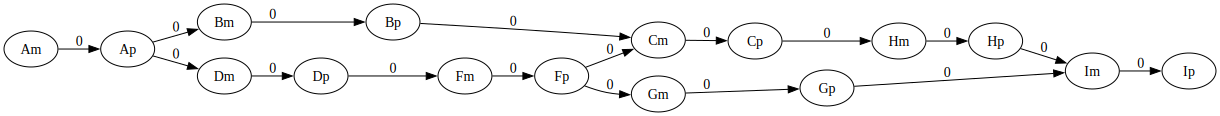

In [23]:
g = graphviz_reader(f"{nomeGrafo}")



#Procedura che converte un grafo G in G* come da paper. Ogni nodo viene 
#convertito in una coppia (u-, u+) collegati da un arco. Tutti gli archi
#uscenti partono da u+ e si collegano agli u- dei successori.

def CONVERT_GRAPH(graph: dict) -> dict:

    g_star = {}

    for v in graph.keys():

       u1 = v + "m"
       u2 = v + "p"
       g_star[u1] = [u2]
       g_star[u2] = list()
       
       for neighbours in g[v]:
        
        next = neighbours + "m"
        g_star[u2].append(next)

    return g_star



g = CONVERT_GRAPH(g)
save_to_graphviz(g, f"{nomeGrafo} convertito", None, None, False)
grafo_convertito = graphviz.Source.from_file(directory="Grafi", filename=f"{nomeGrafo} convertito.dot", format="pdf", engine="dot")
grafo_convertito.render(filename=f"{nomeGrafo} convertito", directory="Immagini", format='pdf', cleanup=True)
grafo_convertito


Procedo quindi ad iniziarlizzare tutti i valori necessari per il calcolo della predecessor_path cover:

In [24]:
#Inizializza i valori di color, PATH FLOW etc..

def reset_colors() -> None:

    for v in color:

        color[v] = 1



def init_values(graph : dict, converted : bool) -> None:

    for node in graph:

        color[node] = 1
        u[node] = 0
        m[node] = 1
        predecessor[node] = []

        for neighbours in graph[node]:

            edge = node + "|" + neighbours

            if converted and ("m" in node):

                demand[edge] = 1

            else:

                demand[edge] = 0
            
            path_flow[edge] = 0


init_values(g, True)


E proseguo successivamente all'implementazione di tutti i metodi necessari alla corretta esecuzione della path cover:

In [25]:
#Aggiorna il numero di vertici scoperti solamente se non erano stati ancora
#effettivamente scoperti. Sottrae quindi uno al valore totale e restituisce
#il valore.

def update_covered_node(node :str, to_be_covered: int) -> int:

    if m[node] == 1:

        m[node] = 0
        to_be_covered -= 1
        
        return to_be_covered

    else:

        return to_be_covered



#Dato che devo riutilizzare questo algoritmo per Ford_Fulkerson, devo poter
#escludere il calcolo di m[v] e u[v] quando necessario tramite il valore 
#booleano path_cover che mi permette di dire di calcolarla (True) o non
#calcolarla (False).

def DFS(path_cover : bool, graph : dict) -> None:

    #Imposto bianchi tutti i vertici.
    if path_cover:

        reset_colors()

    for v in graph.keys():

        if color[v] == 1:

            DFS_VISIT_COVER(v, graph)



def DFS_VISIT_COVER(node: str, graph : dict) -> None:

    #Se una lista di adiancenza è vuota (non ha successori)
  
    if not graph[node]:

        u[node] = m[node]

    else:

        max = -1
        max_node = ""

        for v in graph[node]:

            if color[v] == 1:

                DFS_VISIT_COVER(v, graph)

            if u[v] > max:

                max = u[v]
                max_node = v

        u[node] = m[node] + u[max_node]
        

    color[node] = 0
    topological_order.insert(0, node)



#Visita in profondità utilizzata nel calcolo del flusso tramite l'algoritmo di
#Ford-Fulkerson. Server a riempire il dizionario dei predecessori

def DFS_VISIT_FLOW(node: str, graph : dict) -> None:

    color[node] = 0

    for v in graph[node]:

        if color[v] == 1:

            predecessor[v] = node
            DFS_VISIT_FLOW(v, graph)

   

#Estrae il cammino aumentante dal dizionario dei predecessori

def GET_DFS_PATH(source : str, sink : str) -> None:

    if source == sink:

        predecessor_path.append(source)

    elif predecessor[sink] == []:

        print(f"Non ci sono cammini da {source} a {sink}")
    
    else:

        GET_DFS_PATH(source, predecessor[sink])
        predecessor_path.append(sink)



#Resetta i valori dei predecessori. 

def RESET_PREDECESSOR() -> None:

    for node in predecessor:

        predecessor[node] = []



def PATH_COVER(graph : dict) -> None:

    #Variabile che serve per contare i vertici ancora da scoprire, termino 
    #quando gli ho scoperti tutti

    to_be_covered = len(graph.keys())

    while to_be_covered > 0:

        #Calcolo l'ordinamento topologico per iniziare ad inserire
        #nella cover la sorgente segnangola successivamente come coperta.
        
        #Definisco inoltre un indice per spostarmi direttamente al nodo 
        #massimo tra ogni predecessore.

        DFS(True, graph)
        temp_cover = []
        topological_index = 0
        temp_cover.append(topological_order[0])
        to_be_covered = update_covered_node(topological_order[0], to_be_covered)
        inspected_node = topological_order[topological_index]

        #Attraverso l'ordinamento topologico selezionando il massimo tra
        #ogni predecessore (guardando la lista di adiacenza). Posso eseguire 
        #questa operazione solamente se il nodo ispezionato ha una lista di 
        #adiacenza.

        while not (not graph[inspected_node]):

            max = -1
            max_node = ""

            for w in graph[inspected_node]:

                if u[w] > max:

                    max = u[w]
                    max_node = w


            #Una volta trovato il massimo lo segno come preso m[x] = 0 e lo
            #aggiungo alla copertura, spostandomi successivamente 
            #sull'elemento massimo appena trovato.

            to_be_covered = update_covered_node(max_node, to_be_covered)
            temp_cover.append(max_node)
            path_flow[f"{inspected_node}|{max_node}"] += 1
            topological_index = topological_order.index(max_node)
            inspected_node = topological_order[topological_index]
            

        cover.append(temp_cover.copy())
        temp_cover.clear()
        topological_order.clear()



Il flusso totale attuale nel grafo è dato dal PATH FLOW, calcolato in PATH_COVER ed è il seguente:

['Am', 'Ap', 'Dm', 'Dp', 'Fm', 'Fp', 'Cm', 'Cp', 'Hm', 'Hp', 'Im', 'Ip']
['Am', 'Ap', 'Bm', 'Bp', 'Cm', 'Cp', 'Hm', 'Hp', 'Im', 'Ip']
['Am', 'Ap', 'Dm', 'Dp', 'Fm', 'Fp', 'Gm', 'Gp', 'Im', 'Ip']


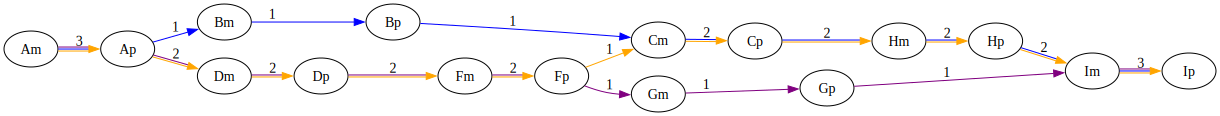

In [26]:
PATH_COVER(g)

for path in cover:

    print(path)

save_to_graphviz(g, f"{nomeGrafo} flow", path_flow, cover, True)
grafo_convertito = graphviz.Source.from_file(directory="Grafi", filename=f"{nomeGrafo} flow.dot", format="pdf", engine="dot")
grafo_convertito.render(filename=f"{nomeGrafo} convertito - path cover", directory="Immagini", format='pdf', cleanup=True)
grafo_convertito

In [27]:
#Mi permette di convertire il grafo residuo (composto da <edge : valore>) in 
#un dizionario composto solo dai nodi e dagli archi presenti nel grafo
#residuo, ovvero nel formato <nodo : [successori]>

def dict_to_graph(d : dict) -> dict:

    graph = {}

    for key in d.keys():

        values = key.split("|")

        if values[0] not in graph:

            graph[values[0]] = []

        if values[1] not in graph:

            graph[values[1]] = []
        
        graph[values[0]].append(values[1])

    return graph



def FORD_FULKERSON() -> None:

    RESIDUAL_GRAPH = path_flow.copy()
    MAX_FLOW = path_flow.copy()

    #Per prima cosa inizializzo i colori per la DFS, non utilizzo la procedura
    #già presente nella DFS perchè quella serve per la path cover. In questo
    #caso i colori vengono modificati man mano dal calcolo del grafo residuo
    #e devono rimanere modificati così per il corretto calcolo di un cammino
    #aumentante e non inizializzati ogni volta a 1.
    
    reset_colors()

    for edge in MAX_FLOW:

        MAX_FLOW[edge] = 0

    for edge in path_flow:

        #c = f(e) - d(e) (per ciascun arco) flusso - domanda

        RESIDUAL_GRAPH[edge] -= demand[edge] 

        #Come detto in precedenza, scarto tutti i valori <= 0 e provvedo già 
        #ad inizializzare i valori per la DFS "scartando" i nodi che non 
        #possono più essere attraversati. Dato che un nodo con valore 0
        #non può più essere attraversato, significa anche che non può
        #ne più essere raggiunto ne collegarsi ad altri nodi in quanto
        #privo di capacità residua. Provvedo quindi ad impostare a 0 il 
        #colore di questo nodo (-, +) per escluderlo dalla DFS.

        if RESIDUAL_GRAPH[edge] <= 0:

            del RESIDUAL_GRAPH[edge]
            
    #Il dizionario del grafo residuo mantiene come valore la capacità residua
    #e non una lista di adiacenza, che è quello che servirebbe per la visita
    #in profondità. Procedo quindi a convertire questo dizionario in un grafo
    #visitabile. Inizializzo anche due variabili per tenere traccia della
    #sorgente e della destinazione di tutti i cammini. Se un cammino
    #aumentante non è dalla sorgente alla destinazione allora il ciclo termina. 

    res_dfs = dict_to_graph(RESIDUAL_GRAPH)


    #Una volta trovata la rete residua, procedo a trovare un cammino aumentante
    #dalla sorgente alla destinazione tramite una visita in profondità. Il
    #cammino aumentante sarà dato proprio dall'ordinamento topologico T come
    #nella path cover.  

    DFS_VISIT_FLOW(source, res_dfs)
    GET_DFS_PATH(source, sink)
    RESET_PREDECESSOR()

    #Una volta che ho trovato il cammino aumentante procedo a trovare il valore
    #minimo (bottleneck) e sottrarlo al dal flusso. Il cammino aumentante
    #ci permette di migliorare l'approssimazione della path cover. Proseguo
    #finché non trovo più cammini aumentanti.

    while predecessor_path:

        print("Cammino aumentante:")
        print(predecessor_path)

        if not(predecessor_path[0] == source and predecessor_path[len(predecessor_path) - 1] == sink):

            break

        print("Il cammino aumentante è nella cover?")
        print(predecessor_path in cover)

        index = 0
        bottleneck = 10000

        #Calcolo il bottleneck (minimo del cammino aumentante)

        while index < len(predecessor_path) - 1:

            edge = predecessor_path[index] + "|" + predecessor_path[index+1]

            if RESIDUAL_GRAPH[edge] < bottleneck:

                bottleneck = RESIDUAL_GRAPH[edge]

            index += 1

        index = 0

        while index < len(predecessor_path) - 1:

            edge = predecessor_path[index] + "|" + predecessor_path[index+1]
            reversed_edge = predecessor_path[index+1] + "|" + predecessor_path[index]
            RESIDUAL_GRAPH[edge] -= bottleneck

            if reversed_edge in RESIDUAL_GRAPH:
                
                RESIDUAL_GRAPH[reversed_edge] += bottleneck

            else:

                RESIDUAL_GRAPH[reversed_edge] = RESIDUAL_GRAPH[edge]

            #Rimuovo gli archi nulli dalla rete residua.
            
            if RESIDUAL_GRAPH[edge] <= 0:

                del RESIDUAL_GRAPH[edge]

            if RESIDUAL_GRAPH[reversed_edge] == 0:
        
                del RESIDUAL_GRAPH[reversed_edge]

            #Sommo il bottleneck al MAX_FLOW
            MAX_FLOW[edge] += bottleneck
            index += 1

        res_dfs = dict_to_graph(RESIDUAL_GRAPH)
        predecessor_path.clear()
        reset_colors()
        DFS_VISIT_FLOW(source, res_dfs)
        GET_DFS_PATH(source, sink)
        RESET_PREDECESSOR()


    print("Nessun percorso disponibile")
   
    #Una volta che non trovo più cammini aumentanti posso procedere a calcolare
    #la path cover finale, ovvero il path_flow - max_flow

    for edge in path_flow:

        path_flow[edge] -= MAX_FLOW[edge]

    for edge in MAX_FLOW:

        if path_flow[edge] == 0:

            del path_flow[edge]

    #Ora che ho in mano il flusso finale, procedo ad effettuare delle visite
    #in profondità per estrarre la cover finale. Ogni volta che estraggo un
    #percorso procedo a sottrarre quel percorso dal flusso attuale in modo
    #tale da poter successivamente cancellare tutti gli archi che hanno
    #capacità 0. 

    #Procedo a svuotare la COVER

    #Faccio una copia del PATH FLOW per tenere salvati i valori sugli archi
    #in modo tale da poterli visualizzare nella stampa del grafo

    cover.clear()
    predecessor_path.clear()
    MIN_FLOW = dict_to_graph(path_flow)
    path_flow_copy = path_flow.copy()

    reset_colors()
    DFS_VISIT_FLOW(source, MIN_FLOW)
    GET_DFS_PATH(source, sink)
    RESET_PREDECESSOR()

    while predecessor_path:

        if not(predecessor_path[0] == source and predecessor_path[len(predecessor_path) - 1] == sink):

            break

        else:

            index = 0
            
            while index < len(predecessor_path) - 1:

                edge = predecessor_path[index] + "|" + predecessor_path[index+1]
                path_flow_copy[edge] -= 1
                index += 1

            for edge in MAX_FLOW:

                if edge in path_flow_copy and path_flow_copy[edge] <= 0:

                    del path_flow_copy[edge]

            MIN_FLOW = dict_to_graph(path_flow_copy)
            cover.append(predecessor_path.copy())
            predecessor_path.clear()

            if MIN_FLOW:

                reset_colors()
                DFS_VISIT_FLOW(source, MIN_FLOW)
                GET_DFS_PATH(source, sink)
                RESET_PREDECESSOR()

            else:

                break
            
    
    print(cover)   

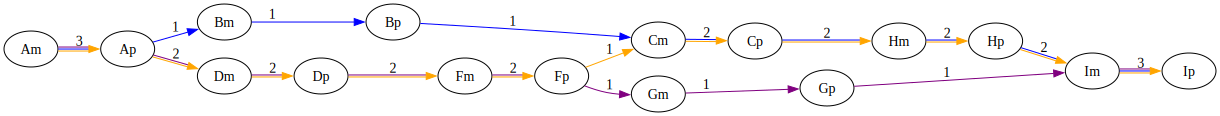

In [28]:
grafo_convertito

Calcolo ora la cover definitiva, tramite l'algoritmod i Ford-Fulkerson:

In [29]:
FORD_FULKERSON()

Cammino aumentante:
['Am', 'Ap', 'Dm', 'Dp', 'Fm', 'Fp', 'Cm', 'Cp', 'Hm', 'Hp', 'Im', 'Ip']
Il cammino aumentante è nella cover?
True
Non ci sono cammini da Am a Ip
Nessun percorso disponibile
[['Am', 'Ap', 'Bm', 'Bp', 'Cm', 'Cp', 'Hm', 'Hp', 'Im', 'Ip'], ['Am', 'Ap', 'Dm', 'Dp', 'Fm', 'Fp', 'Gm', 'Gp', 'Im', 'Ip']]


La path cover finale ottenuta è la seguente:

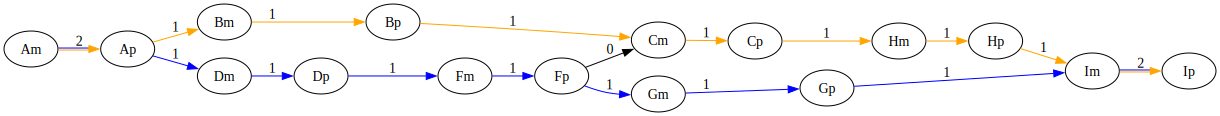

In [30]:
save_to_graphviz(g, f"{nomeGrafo} cover", path_flow, cover, True)
grafo_cover = graphviz.Source.from_file(directory="Grafi", filename=f"{nomeGrafo} cover.dot", format="pdf", engine="dot")
grafo_cover.render(filename=f"{nomeGrafo} convertito - path cover minima", directory="Immagini", format='pdf', cleanup=True)
grafo_cover

